In [1]:
#####Generalized Factorization Machines#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [3]:
###データの生成####
##データの設定
s = 3
k1 = 10
k2 = 10
k3 = 7
hh = 3750
item = 5000
element = 200
pt1 = np.random.poisson(37.5, hh)
pt2 = np.random.poisson(20.0, hh)
hhpt1 = np.sum(pt1)
hhpt2 = np.sum(pt2)
k_vec1 = np.repeat(1, k1)
k_vec2 = np.repeat(1, k2)
k_vec3 = np.repeat(1, k3)

In [4]:
##IDとインデックスの設定
#IDの設定
d_id1 = np.array(np.repeat(np.arange(hh), pt1), dtype="int16")
d_id2 = np.array(np.repeat(np.arange(hh), pt2), dtype="int16")
pt_id1 = np.array(list(itertools.chain(*[np.array(range(pt1[i]), dtype="int") for i in range(hh)])), dtype="int16")
pt_id2 = np.array(list(itertools.chain(*[np.array(range(pt2[i]), dtype="int") for i in range(hh)])), dtype="int16")

#インデックスの設定
d_list1 = [i for i in range(hh)]
d_list2 = [i for i in range(hh)]
for i in range(hh):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")
    d_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int")

In [5]:
##アイテムを生成
#レコードごとの頻度を生成
gamma01 = np.random.gamma(1.0, 1/0.25, hh)[d_id1]
gamma02 = np.random.gamma(1.0, 1/0.25, hh)[d_id1]
freq1 = np.random.poisson(gamma01, hhpt1)
freq2 = np.random.poisson(gamma02, hhpt1)
freq1[freq1 < 3] = 3; freq2[freq2 < 3] = 3
max_freq1 = np.max(freq1)
max_freq2 = np.max(freq2)

#トピックのパラメータを生成
topic = 25
theta0 = np.random.dirichlet(np.repeat(0.5, topic), hh)
phi_item = np.random.dirichlet(np.repeat(0.5, item), topic)
phi_element = np.random.dirichlet(np.repeat(0.5, element), topic)
z2 = np.array(rmnom(theta0[d_id2, ], hhpt2, topic, 0), dtype="int")

#トピックとアイテムの格納用配列
z11 = np.full((hhpt1, max_freq1), topic, dtype="int16")
z12 = np.full((hhpt1, max_freq2), topic, dtype="int16")
item_id11 = np.full((hhpt1, max_freq1), item, dtype="int16")
item_id12 = np.full((hhpt1, max_freq2), item, dtype="int16")
item_id2 = np.array(np.repeat(0, hhpt2), dtype="int16")

#多項分布からアイテムを生成
for i in range(hhpt1):
    index1 = np.arange(freq1[i])
    index2 = np.arange(freq2[i])
    z11[i, index1] = np.array(rmnom(theta0[d_id1[np.repeat(i, freq1[i])], ], freq1[i], topic, 0), dtype="int16")
    z12[i, index2] = np.array(rmnom(theta0[d_id1[np.repeat(i, freq2[i])], ], freq2[i], topic, 0), dtype="int16")
    item_id11[i, index1] = np.array(rmnom(phi_item[z11[i, index1], ], freq1[i], item, 0), dtype="int16")
    item_id12[i, index2] = np.array(rmnom(phi_item[z12[i, index2], ], freq2[i], item, 0), dtype="int16")
    
for i in range(hh):
    item_id2[d_list2[i]] = np.array(rmnom(phi_item[z2[d_list2[i]], ], pt2[i], item, 0), dtype="int16")

In [6]:
##エレメントを生成
#エレメントの格納用配列
element_id11 = np.full((hhpt1, max_freq1), item, dtype="int16")
element_id12 = np.full((hhpt1, max_freq2), item, dtype="int16")
element_id2 = np.array(np.repeat(0, hhpt2), dtype="int16")

#多項分布からエレメントを生成
for i in range(hhpt1):
    index1 = np.arange(freq1[i])
    index2 = np.arange(freq2[i])
    element_id11[i, index1] = np.array(rmnom(phi_element[z11[i, index1], ], freq1[i], element, 0), dtype="int16")
    element_id12[i, index2] = np.array(rmnom(phi_element[z12[i, index2], ], freq2[i], element, 0), dtype="int16")

In [7]:
##レコード単位に拡張したidとインデックスを作成
#レコード単位のidを作成
N1 = np.sum(freq1)
N2 = np.sum(freq2)
record_id1 = np.repeat(np.arange(hhpt1), freq1)
record_id2 = np.repeat(np.arange(hhpt1), freq2)

#拡張したidを作成
d_long1 = np.repeat(d_id1, freq1); d_long2 = np.repeat(d_id1, freq2)
item_long1 = item_id11[item_id11 < item]; item_long2 = item_id12[item_id12 < item]
element_long1 = element_id11[element_id11 < element]; element_long2 = element_id12[element_id12 < element]

#idのフラッグを作成
Zi1 = sparse.coo_matrix((np.repeat(1, N1), (np.arange(N1), record_id1)), shape=(N1, hhpt1))
Zi2 = sparse.coo_matrix((np.repeat(1, N2), (np.arange(N2), record_id2)), shape=(N2, hhpt1))

#レコードのインデックスを作成
record_list1 = [i for i in range(hhpt1)]
record_list2 = [i for i in range(hhpt1)]
record_index1 = [i for i in range(hhpt1)]
record_index2 = [i for i in range(hhpt1)]
for i in range(hhpt1):
    record_list1[i] = np.array(np.where(record_id1==i)[0], dtype="int")
    record_list2[i] = np.array(np.where(record_id2==i)[0], dtype="int")
    record_index1[i] = np.array(np.arange(freq1[i]), dtype="int8")
    record_index2[i] = np.array(np.arange(freq2[i]), dtype="int8")

In [8]:
####応答変数を生成####
##パラメータを生成
#事前分布を設定
alpha1 = np.array([0])
alpha21 = np.repeat(0.0, k1)
alpha22 = np.repeat(0.0, k2)
alpha23 = np.repeat(0.0, k3)
tau_u = np.array([0.4, 0.4, 0.6])
Cov_u = np.diag(np.repeat(0.25, k1))
Cov_v = np.diag(np.repeat(0.25, k2))
Cov_e = np.diag(np.repeat(0.2, k3))
tau = np.array([0.3, 0.3, 0.5])
taut_u = tau_u.copy(); taut = tau.copy()
Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy(); Covt_e = Cov_e.copy()

#パラメータを生成
Sigma = np.array([0.4, 0.4, 1.0])
beta = np.array([-0.2, -0.2, 0.0])
beta_u11 = np.random.normal(0, tau_u[0], hh)
beta_u12 = np.random.normal(0, tau_u[1], hh)
beta_u2 = np.random.normal(0, tau_u[2], hh)
theta_u = np.random.multivariate_normal(alpha21, Cov_u, hh)
theta_v = np.random.multivariate_normal(alpha22, Cov_v, item)
theta_e = np.random.multivariate_normal(alpha23, Cov_e, element)
omega11 = np.random.normal(0, tau[0], k1*k2*k3).reshape(k2, k3, k1)
omega12 = np.random.normal(0, tau[1], k1*k2*k3).reshape(k2, k3, k1)
omega2 = np.random.normal(0, tau[2], k1*k2*k3).reshape(k2, k3, k1)
betat = beta.copy(); betat_u11 = beta_u11.copy(); betat_u12 = beta_u12.copy(); betat_u2 = beta_u2.copy()
thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_e = theta_e.copy()
omegat11 = omega11.copy(); omegat12 = omega12.copy(); omegat2 = omega2.copy()
Sigmat = Sigma.copy()

##モデルの期待値を計算
#特徴行列のパラメータを拡張
theta_element11 = theta_e[element_long1, ]; theta_user11 = theta_u[d_long1, ]
theta_element12 = theta_e[element_long2, ]; theta_user12 = theta_u[d_long2, ]
theta_element2 = theta_e[element_id2, ]; theta_user2 = theta_u[d_id2, ]

#タッカー分解の期待値
uv_long11 = np.repeat(0.0, N1)
uv_long12 = np.repeat(0.0, N2)
uv2 = np.repeat(0.0, hhpt2)
for j in range(k1):
    uv_long11 += np.dot(np.dot(theta_v, omega11[:, :, j])[item_long1, ] * theta_element11 * theta_user11[:, j][:, np.newaxis], k_vec3)
    uv_long12 += np.dot(np.dot(theta_v, omega12[:, :, j])[item_long2, ] * theta_element12 * theta_user12[:, j][:, np.newaxis], k_vec3)
    uv2 += np.dot(np.dot(theta_v, omega2[:, :, j])[item_id2, ] * theta_element2 * theta_user2[:, j][:, np.newaxis], k_vec3)
uv11 = np.array(np.dot(sparse.csr_matrix(uv_long11), Zi1).todense()).reshape(-1)
uv12 = np.array(np.dot(sparse.csr_matrix(uv_long12), Zi2).todense()).reshape(-1)

#期待値を計算
mu1 = beta[0] + beta_u11[d_id1] + uv11
mu2 = beta[1] + beta_u12[d_id1] + uv12
mu3 = beta[2] + beta_u2[d_id2] + uv2 


##正規分布から連続応答変数と二値応答変数を生成
#連続応答変数を生成
y1 = np.random.normal(mu1, Sigma[0], hhpt1)
y2 = np.random.normal(mu2, Sigma[1], hhpt1)

#潜在効用から二値応答変数を生成
U = np.random.normal(mu3, Sigma[2], hhpt2); UT = U.copy()
y3 = (U >= 0)*1 + (U < 0)*0   #購買有無に変換
Prob = norm.cdf(mu3, 0, Sigma[2])

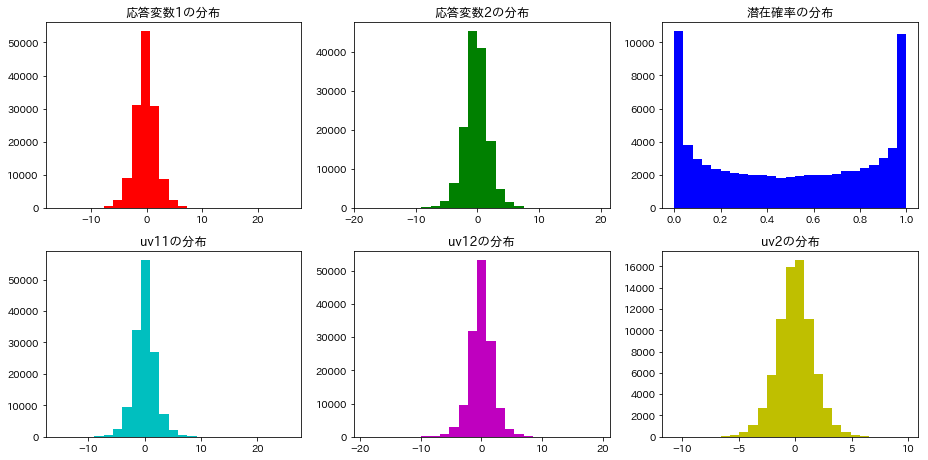

In [9]:
#生成したデータのヒストグラム
dt = [y1, y2, Prob, uv11, uv12, uv2]
fig_range = np.append(np.array([np.min(y1), np.min(y2), 0, np.min(uv11), np.min(uv12), np.min(uv2)]), 
                      np.array([np.max(y1), np.max(y2), 1, np.max(uv11), np.max(uv12), np.max(uv2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答変数1の分布", "応答変数2の分布", "潜在確率の分布", "uv11の分布", "uv12の分布", "uv2の分布"]
fig = plt.figure(figsize=(13.0, 6.5))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
####マルコフ連鎖モンテカルロ法でGeneralized Factorization Machinesを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [11]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [12]:
##アルゴリズムの設定
R = 2000
keep = 2
burnin = int(100/keep)
iter = 0
disp = 10

In [13]:
##データの設定
#切断領域を定義
rho = 10.0
a = np.array((1-y3)*(-rho) + y3*0)
b = np.array(y3*rho + (1-y3)*0)
flag =  y3 - (1-y3)

#データソースを1つに統合
hhpt = np.array([hhpt1, hhpt1, hhpt2])
pt = np.hstack((pt1[:, np.newaxis], pt1[:, np.newaxis], pt2[:, np.newaxis]))
d_list = [d_list1, d_list1, d_list2]
d_weight = pt / np.sum(pt, axis=1)[:, np.newaxis]

In [14]:
##事前分布の設定
#階層モデルの事前分布
alpha1 = np.array([0.0])
alpha21 = np.repeat(0.0, k1)
alpha22 = np.repeat(0.0, k2)
alpha23 = np.repeat(0.0, k3)
V1 = 0.1 * np.diag(np.repeat(1.0, k1))
V2 = 0.1 * np.diag(np.repeat(1.0, k2))
V3 = 0.1 * np.diag(np.repeat(1.0, k3))
nu = 1
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [15]:
##パラメータの真値
#階層モデルのパラメータの真値
tau_u = taut_u.copy()
Cov_u = Covt_u.copy()
Cov_v = Covt_v.copy()
Cov_e = Covt_e.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)
inv_Cov_e = np.linalg.inv(Cov_e)

#モデルパラメータの真値
Sigma = Sigmat.copy()
beta = betat.copy()
beta_u11 = betat_u11.copy()
beta_u12 = betat_u12.copy()
beta_u2 = betat_u2.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_e = thetat_e.copy()
omega11 = omegat11.copy()
omega12 = omegat12.copy()
omega2 = omegat2.copy()

In [16]:
##モデルの期待値を計算
#パラメータを拡張
beta_user11 = beta_u11[d_id1]
beta_user12 = beta_u12[d_id1]
beta_user2 = beta_u2[d_id2]
theta_element11 = theta_e[element_long1, ]; theta_user11 = theta_u[d_long1, ]
theta_element12 = theta_e[element_long2, ]; theta_user12 = theta_u[d_long2, ]
theta_element2 = theta_e[element_id2, ]; theta_user2 = theta_u[d_id2, ]

#タッカー分解の期待値
uv_long11 = np.repeat(0.0, N1)
uv_long12 = np.repeat(0.0, N2)
uv2 = np.repeat(0.0, hhpt2)
for j in range(k1):
    uv_long11 += np.dot(np.dot(theta_v, omega11[:, :, j])[item_long1, ] * theta_element11 * theta_user11[:, j][:, np.newaxis], k_vec3)
    uv_long12 += np.dot(np.dot(theta_v, omega12[:, :, j])[item_long2, ] * theta_element12 * theta_user12[:, j][:, np.newaxis], k_vec3)
    uv2 += np.dot(np.dot(theta_v, omega2[:, :, j])[item_id2, ] * theta_element2 * theta_user2[:, j][:, np.newaxis], k_vec3)
uv11 = np.array(np.dot(sparse.csr_matrix(uv_long11), Zi1).todense()).reshape(-1)
uv12 = np.array(np.dot(sparse.csr_matrix(uv_long12), Zi2).todense()).reshape(-1)

#期待値を計算
mu1 = beta[0] + beta_u11[d_id1] + uv11
mu2 = beta[1] + beta_u12[d_id1] + uv12
mu3 = beta[2] + beta_u2[d_id2] + uv2 

In [17]:
##パラメータの格納用配列
#階層モデルのパラメータの格納用配列
TAU_U = np.zeros((int(R/keep), s))
COV_U = np.zeros((k1, k1, int(R/keep)))
COV_V = np.zeros((k2, k2, int(R/keep)))
COV_E = np.zeros((k3, k3, int(R/keep)))

#モデルパラメータの格納用配列
SIGMA = np.zeros((int(R/keep), s))
BETA = np.zeros((int(R/keep), s))
BETA_U11 = np.zeros((int(R/keep), hh))
BETA_U12 = np.zeros((int(R/keep), hh))
BETA_U2 = np.zeros((int(R/keep), hh))
THETA_U = np.zeros((hh, k1, int(R/keep)))
THETA_V = np.zeros((item, k2, int(R/keep)))
THETA_E = np.zeros((element, k3, int(R/keep)))
OMEGA11 = np.zeros((k2, k3, k1, int(R/keep)))
OMEGA12 = np.zeros((k2, k3, k1, int(R/keep)))
OMEGA2 = np.zeros((k2, k3, k1, int(R/keep)))

In [35]:
####ギブスサンプリングでパラメタータをサンプリング####

##モデルの期待値計算と潜在効用の生成
#タッカー分解の期待値
AR11 = np.zeros((k1, N1)); AR12 = np.zeros((k1, N2)); AR2 = np.zeros((hhpt2, k1))
uv_long11 = np.repeat(0.0, N1); uv_long12 = np.repeat(0.0, N2); uv2 = np.repeat(0.0, hhpt2)
for j in range(k1):
    ar11 = np.dot(theta_v, omega11[:, :, j])[item_long1, ] * theta_element11
    ar12 = np.dot(theta_v, omega12[:, :, j])[item_long2, ] * theta_element12
    ar2 = np.dot(theta_v, omega2[:, :, j])[item_id2, ] * theta_element2
    uv_long11 += np.dot(ar11 * theta_user11[:, j][:, np.newaxis], k_vec3)
    uv_long12 += np.dot(ar12 * theta_user12[:, j][:, np.newaxis], k_vec3)
    uv2 += np.dot(ar2 * theta_user2[:, j][:, np.newaxis], k_vec3)
    AR11[j, ] = np.dot(ar11, k_vec3)
    AR12[j, ] = np.dot(ar12, k_vec3)
    AR2[:, j] = np.dot(ar2, k_vec3)
    
#レコード単位で和を取る
uv11 = np.array(np.dot(sparse.csr_matrix(uv_long11), Zi1).todense()).reshape(-1)
uv12 = np.array(np.dot(sparse.csr_matrix(uv_long12), Zi2).todense()).reshape(-1)

#期待値を計算
mu1 = beta[0] + beta_user11 + uv11
mu2 = beta[1] + beta_user12 + uv12
mu3 = beta[2] + beta_user2 + uv2 
mu = [mu1, mu2, mu3]

#切断正規分布から潜在効用を生成
U = rtnorm(mu3, Sigma[2], a, b, hhpt2)
y = [y1, y2, U]

In [29]:
##モデルの期待値パラメータをサンプリング
#モデル誤差を定義
Sigma_sq = np.power(Sigma, 2)
er_y1 = y1 - beta_user11 - uv11
er_y2 = y2 - beta_user12 - uv12
er_y3 = U - beta_user2 - uv2
er_y = [er_y1, er_y2, er_y3]

#正規分布から期待値をサンプリング
weights = np.power(tau, 2) / (Sigma_sq/hhpt + np.power(tau, 2))
mu_par = weights * np.array([np.mean(er_y[j]) for j in range(s)])
beta = np.random.normal(mu_par, weights*Sigma_sq/hhpt, s)

In [30]:
##ランダム効果のパラメータをサンプリング
#モデル誤差を定義
er_y1 = y1 - beta[0] - uv11
er_y2 = y2 - beta[1] - uv12
er_y3 = y3 - beta[2] - uv2
er_y = [er_y1, er_y2, er_y3]

#正規分布からランダム効果をサンプリング
for i in range(hh):
    weights = tau_u / (Sigma_sq/pt[i, ] + tau_u)
    mu_par = weights * np.array([np.mean(er_y[j][d_list[j][i]]) for j in range(s)])
    beta_u = np.random.normal(mu_par, weights*Sigma_sq/pt[i, ], s)
    beta_u11[i] = beta_u[0]
    beta_u12[i] = beta_u[1]
    beta_u2[i] = beta_u[2]
    
#パラメータを更新
beta_user11 = beta_u11[d_id1]
beta_user12 = beta_u12[d_id1]
beta_user2 = beta_u2[d_id2]

In [31]:
##ユーザーの特徴行列をサンプリング
#モデル誤差と入力変数を定義
X1 = np.array(np.dot(sparse.coo_matrix(AR11), Zi1).T.todense())
X2 = np.array(np.dot(sparse.coo_matrix(AR12), Zi2).T.todense())
er_y1 = y1 - beta[0] - beta_user11
er_y2 = y2 - beta[1] - beta_user12
er_y3 = y3 - beta[2] - beta_user2

#多変量正規分布から事後分布をサンプリング
for i in range(hh):
    index1 = d_list1[i]; index2 = d_list2[i]
    x = np.vstack((X1[index1, ], X2[index1, ], AR2[index2, ]))
    er_y = np.append(np.append(er_y1[index1], er_y2[index1]), er_y3[index2])
    xy = np.dot(x.T, er_y)
    xxv = np.dot(x.T, x) + inv_Cov_u
    inv_xxv = np.linalg.inv(xxv)
    theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_u, alpha21))
    theta_u[i, ] = np.random.multivariate_normal(theta_par, np.sum(Sigma_sq*d_weight[i, ])*inv_xxv, 1)
    
#パラメータを更新
theta_user11 = theta_u[d_long1, ]
theta_user12 = theta_u[d_long2, ]
theta_user2 = theta_u[d_id2, ]

In [61]:
##アイテムの特徴行列をサンプリング
#タッカー分解の期待値
theta_item11 = theta_v[item_long1, ]; theta_item12 = theta_v[item_long2, ]; theta_item2 = theta_v[item_id2, ]
AR11 = np.zeros((N1, k2)); AR12 = np.zeros((N2, k2)); AR2 = np.zeros((hhpt2, k2))
uv_long11 = np.repeat(0.0, N1); uv_long12 = np.repeat(0.0, N2); uv2 = np.repeat(0.0, hhpt2)
for j in range(k1):
    ar11 = np.dot(theta_e, omega11[:, :, j].T)[element_long1, ] * theta_user11[:, j][:, np.newaxis]
    ar12 = np.dot(theta_e, omega12[:, :, j].T)[element_long2, ] * theta_user12[:, j][:, np.newaxis]
    ar2 = np.dot(theta_e, omega2[:, :, j].T)[element_id2, ] * theta_user2[:, j][:, np.newaxis]
    uv_long11 += np.dot(ar11 * theta_item11, k_vec2)
    uv_long12 += np.dot(ar12 * theta_item12, k_vec2)
    uv2 += np.dot(ar2 * theta_item2, k_vec2)
    AR11 += ar11; AR12 += ar12; AR2 += ar2

In [62]:
uv_long11

array([-0.32799043,  0.9833797 ,  0.2966996 , ...,  0.20990175,
       -0.9121072 ,  0.19437327])

In [63]:
u1

array([-0.32799043,  0.9833797 ,  0.2966996 , ...,  0.20990175,
       -0.9121072 ,  0.19437327])

In [ ]:
for j in range(k3):
    X += np.dot(theta_v, omega[:, :, j].T)[item_id, ] * theta_vec3[:, j][:, np.newaxis]

In [ ]:
#タッカー分解の期待値
AR11 = np.zeros((k1, N1)); AR12 = np.zeros((k1, N2)); AR2 = np.zeros((hhpt2, k1))
uv_long11 = np.repeat(0.0, N1); uv_long12 = np.repeat(0.0, N2); uv2 = np.repeat(0.0, hhpt2)
for j in range(k1):
    ar11 = np.dot(theta_v, omega11[:, :, j])[item_long1, ] * theta_element11
    ar12 = np.dot(theta_v, omega12[:, :, j])[item_long2, ] * theta_element12
    ar2 = np.dot(theta_v, omega2[:, :, j])[item_id2, ] * theta_element2
    uv_long11 += np.dot(ar11 * theta_user11[:, j][:, np.newaxis], k_vec3)
    uv_long12 += np.dot(ar12 * theta_user12[:, j][:, np.newaxis], k_vec3)
    uv2 += np.dot(ar2 * theta_user2[:, j][:, np.newaxis], k_vec3)
    AR11[j, ] = np.dot(ar11, k_vec3)
    AR12[j, ] = np.dot(ar12, k_vec3)
    AR2[:, j] = np.dot(ar2, k_vec3)

In [57]:
u1 = uv_long11.copy()
u2 = uv_long12.copy()
u3 = uv2.copy()